# Analysis robustness of PLIER models based on GTEx

Marc Subirana-Granés (2024)

Compare the various parameters of PLIER GTEx models across different computations to evaluate PLIER's robustness, utilizing identical parameters for assessment.

In [1]:
INPUT_PLIER_ROB_DIR=NULL

In [2]:
# Parameters
INPUT_PLIER_ROB_DIR = "output/gtex/robustness"


## Load libraries and data

In [3]:
suppressPackageStartupMessages({
    
    library(dplyr)
    library(tidyr)
    library(UpSetR)
    library(ggplot2)
    library(ComplexHeatmap)
    library(reshape2)
    library(corrr)
    library(assertthat)

    
})

#load functions
source(here::here('scripts/plier_util.R'))

# move functions to a Rscript?
check_all_equal_in_list <- function(lst) {
  # Check if all values in the list are equal
  all_equal <- all(sapply(lst, function(x) identical(x, lst[[1]])))
  
  # Print message based on the result
  if (all_equal) {
    print("All values in the list are equal.")
  } else {
    print("Values in the list are not all equal.")
  }
  
}

assert_that(!is.null(INPUT_PLIER_ROB_DIR), msg = "Input robustness PLIER models path was not specified")
INPUT_PLIER_ROB_DIR=here::here(INPUT_PLIER_ROB_DIR)

[1] TRUE

## Robustness analysis

Extract all the parameters in the PLIER module for each GTEx module and create a list for each parameter and load models into a list object. 

In [4]:
gtex_rob_model_paths=list.files(INPUT_PLIER_ROB_DIR,
                                pattern="\\.rds",
                                full.names=TRUE)

parameters_to_keep <- c("L1", "L2", "L3", "B", "C", "heldOutGen", "residual", "summary", "U", "Uauc", "Z", "Up", "withPrior")

# Initialize a list to store the extracted values for each parameter, considering their data types
extracted_values <- setNames(lapply(parameters_to_keep, function(x) list()), parameters_to_keep)

# Function to handle different types of data structures
handle_data_type <- function(data, param) {
  # Depending on the specific requirements or handling you need for each type, adjust here
  return(data[[param]])
}

# Read each file once and extract all specified parameters, handling them based on their type
all_models_data <- lapply(gtex_rob_model_paths, function(file_path) {
  plier_model <- readRDS(file_path)
  # Extract and handle each needed parameter for this model
  needed_params <- sapply(parameters_to_keep, function(param) handle_data_type(plier_model, param), simplify = FALSE)
  names(needed_params) <- parameters_to_keep
  return(needed_params)
})

# Organize the extracted data by parameter
for(param in parameters_to_keep) {
  extracted_values[[param]] <- lapply(all_models_data, function(model_data) model_data[[param]])
}

                                      
gtex_rob_model_paths=list.files(INPUT_PLIER_ROB_DIR,
    pattern="\\.rds",
    full.names=TRUE)
                                    
# All models into a list
gtex_rob_models=lapply(gtex_rob_model_paths, readRDS)

**Are the L1, L2 and L3 parameters identical along the different GTEx models run?**

**L1**

In [5]:
extracted_values$L1
check_all_equal_in_list(extracted_values$L1)                          

[[1]]
[1] 27.76998

[[2]]
[1] 27.76998

[[3]]
[1] 27.76998

[[4]]
[1] 27.76998

[[5]]
[1] 27.76998

[[6]]
[1] 27.76998

[[7]]
[1] 27.76998

[[8]]
[1] 27.76998

[[9]]
[1] 27.76998

[[10]]
[1] 27.76998

[1] "All values in the list are equal."


**L2**

In [6]:
extracted_values$L2
check_all_equal_in_list(extracted_values$L2)                          

[[1]]
[1] 55.53997

[[2]]
[1] 55.53997

[[3]]
[1] 55.53997

[[4]]
[1] 55.53997

[[5]]
[1] 55.53997

[[6]]
[1] 55.53997

[[7]]
[1] 55.53997

[[8]]
[1] 55.53997

[[9]]
[1] 55.53997

[[10]]
[1] 55.53997

[1] "All values in the list are equal."


**L3**

In [7]:
extracted_values$L3
check_all_equal_in_list(extracted_values$L3)                          

[[1]]
[1] 0.001033298

[[2]]
[1] 0.001033298

[[3]]
[1] 0.001033298

[[4]]
[1] 0.001033298

[[5]]
[1] 0.001033298

[[6]]
[1] 0.001033298

[[7]]
[1] 0.001033298

[[8]]
[1] 0.001033298

[[9]]
[1] 0.001033298

[[10]]
[1] 0.001033298

[1] "All values in the list are equal."


**How similar are the Z matrices along the different models?**

To study how similar are the Z matrices we will calcuate:

- MASE (mean absolute scaled error) between the two Z gene expression matrices.
- Spearman Correlation between the two Z gene expression matrices.

We expected a low MASE and a high rho (arround 1) if the models are similar. 

We also expect a inverse correlation between MASE and Spearman Correlation.

Do the present the same number of LVs and genes?

In [8]:
matricesZ <- extracted_values$Z
lapply(matricesZ, ncol)

[[1]]
[1] 1042

[[2]]
[1] 1042

[[3]]
[1] 1042

[[4]]
[1] 1042

[[5]]
[1] 1042

[[6]]
[1] 1042

[[7]]
[1] 1042

[[8]]
[1] 1042

[[9]]
[1] 1042

[[10]]
[1] 1042

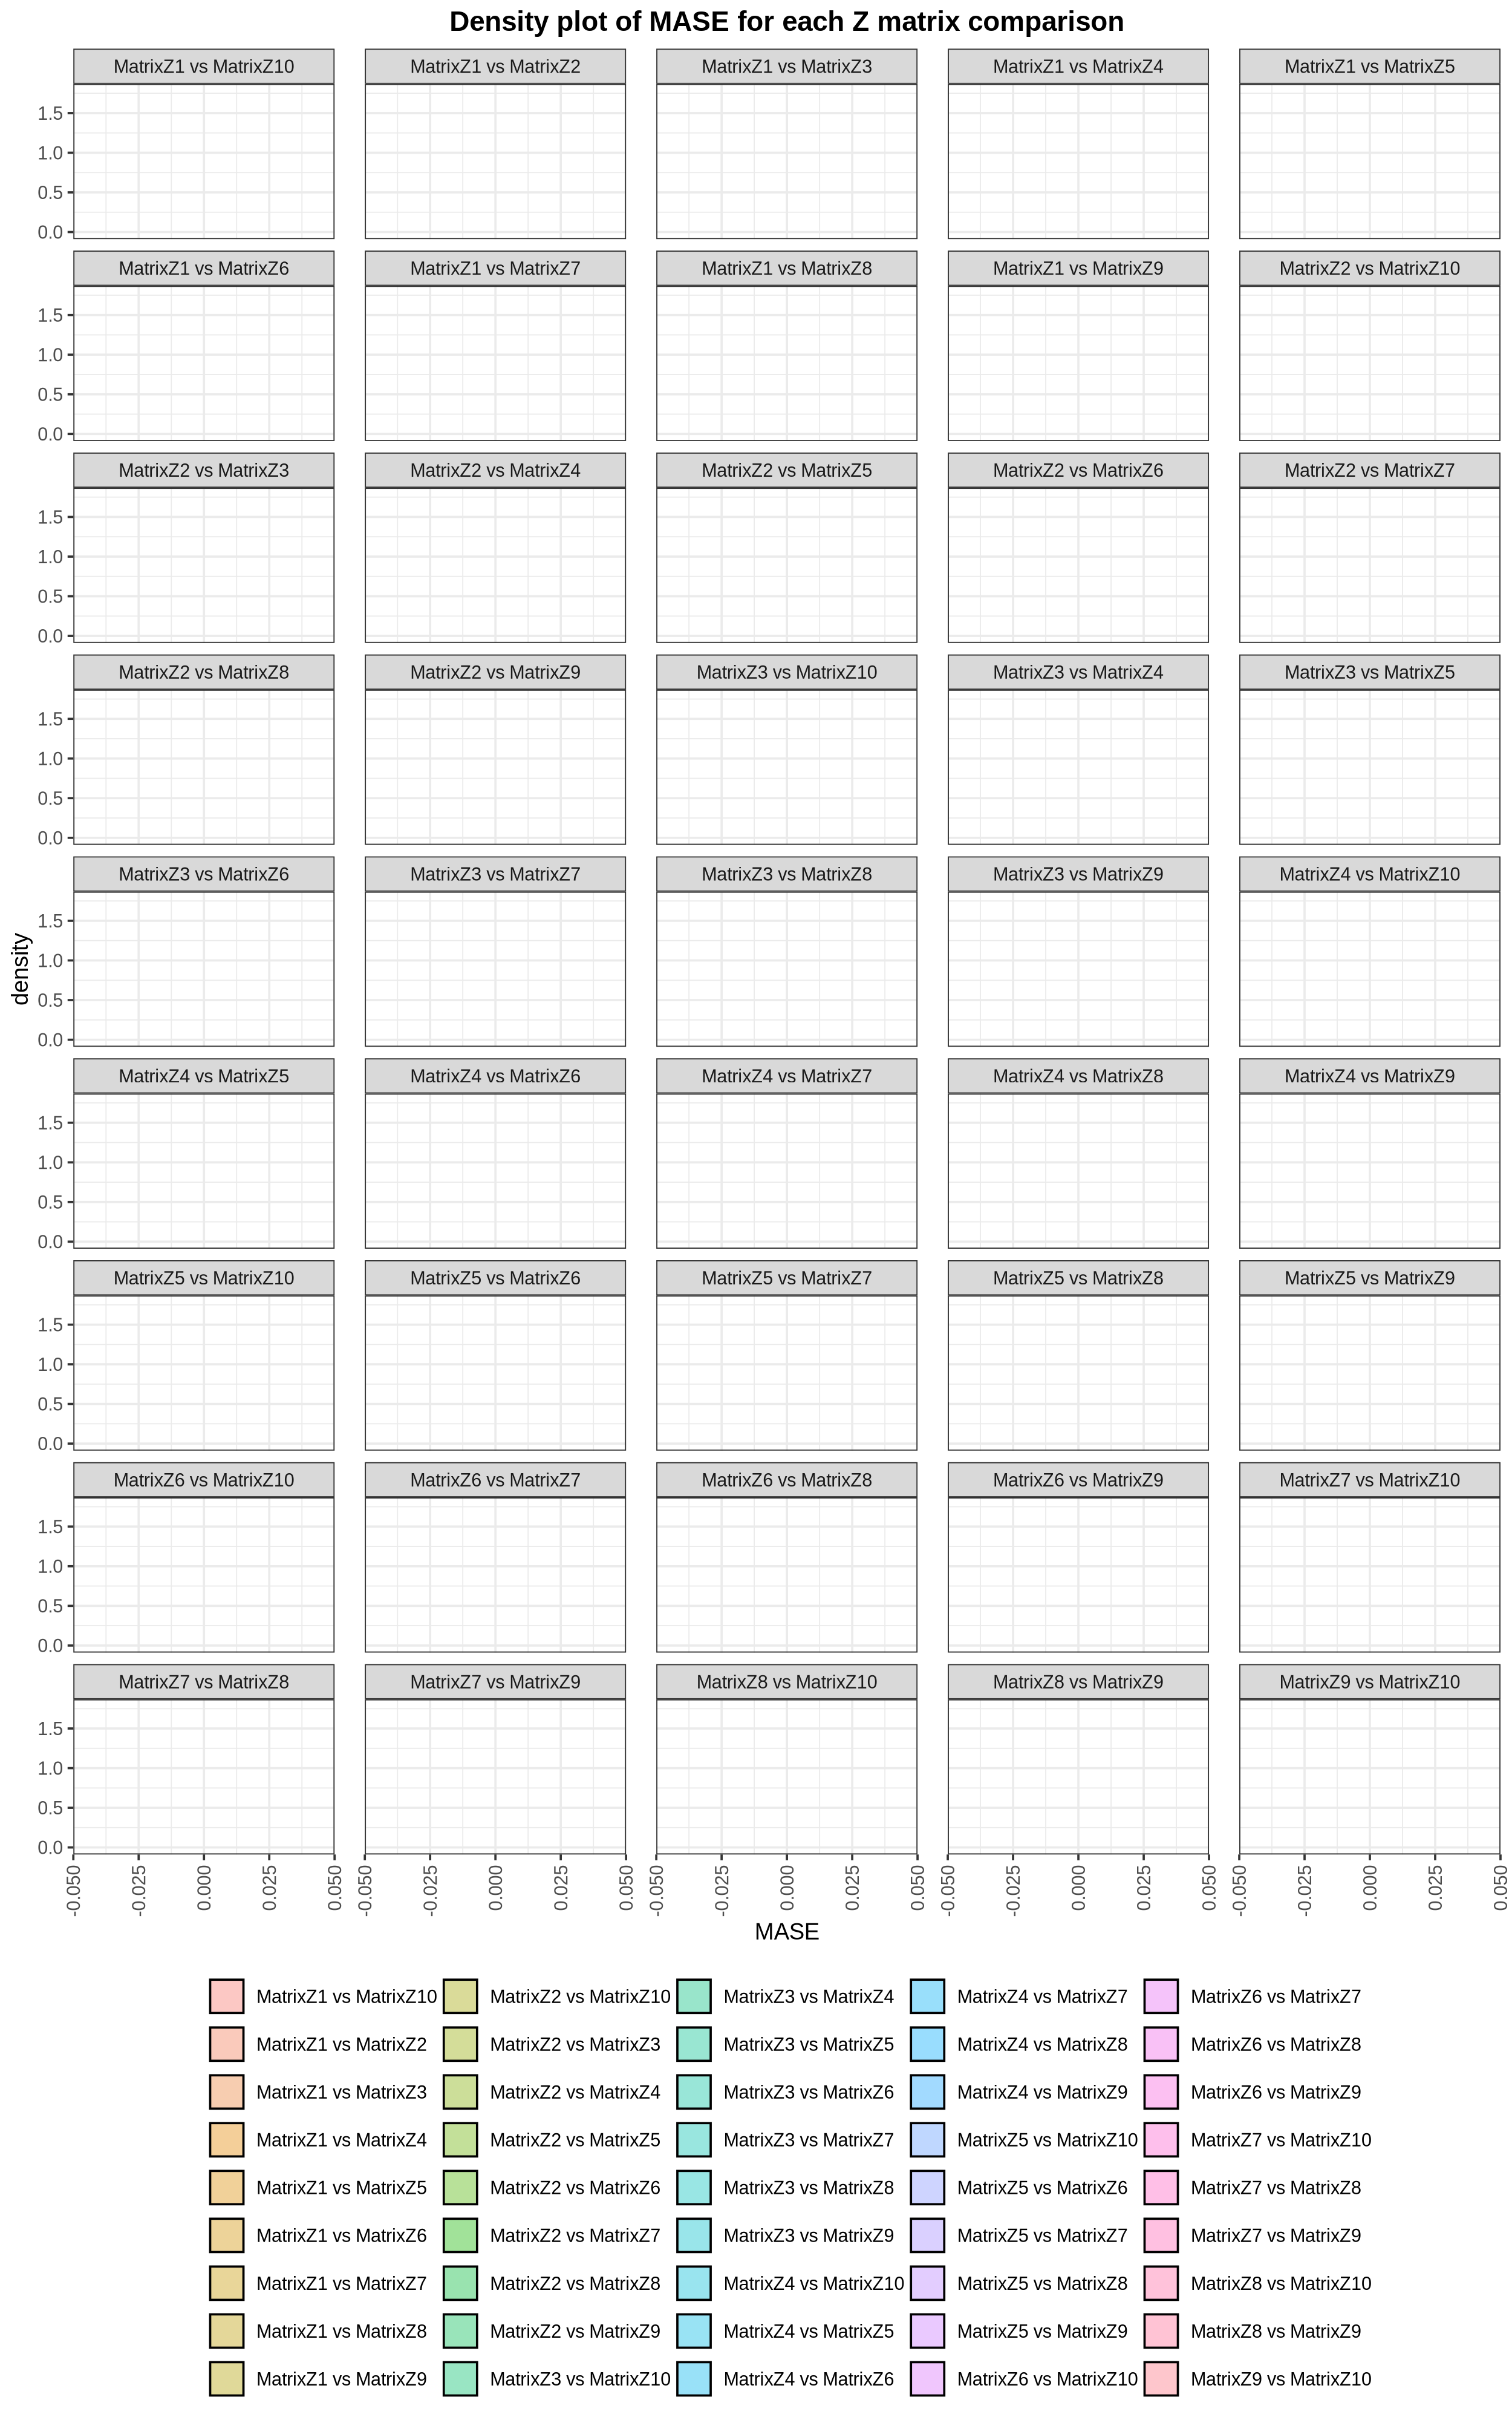

In [9]:
results_mase <- data.frame()

# Compute MASE for each combination
for (i in 1:(length(matricesZ) - 1)) {
  for (j in (i + 1):length(matricesZ)) {
    mase_value <- GetReconstructionMASE(matricesZ[[i]], matricesZ[[j]])
    comparison_name <- paste("MatrixZ", i, " vs MatrixZ", j, sep = "")
    tmp_df=data.frame(comparison=comparison_name, mase=mase_value)
    results_mase <- rbind(results_mase, data.frame(comparison = comparison_name, mase = mase_value))
  }
}

# Convert mase to a numeric vector to ensure proper plotting
results_mase$mase <- as.numeric(results_mase$mase)

options(repr.plot.width = 10, repr.plot.height = 16, repr.plot.res = 250)

ggplot(results_mase, aes(x = mase, fill = comparison)) +  
  geom_density(alpha = 0.4) +
  theme_bw() +
  labs(x = "MASE", 
       title = "Density plot of MASE for each Z matrix comparison") +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.title = element_blank(),
        legend.position = 'bottom',
               axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
        panel.spacing.x = unit(1, "lines")) +
  facet_wrap(~ comparison, ncol = 5)

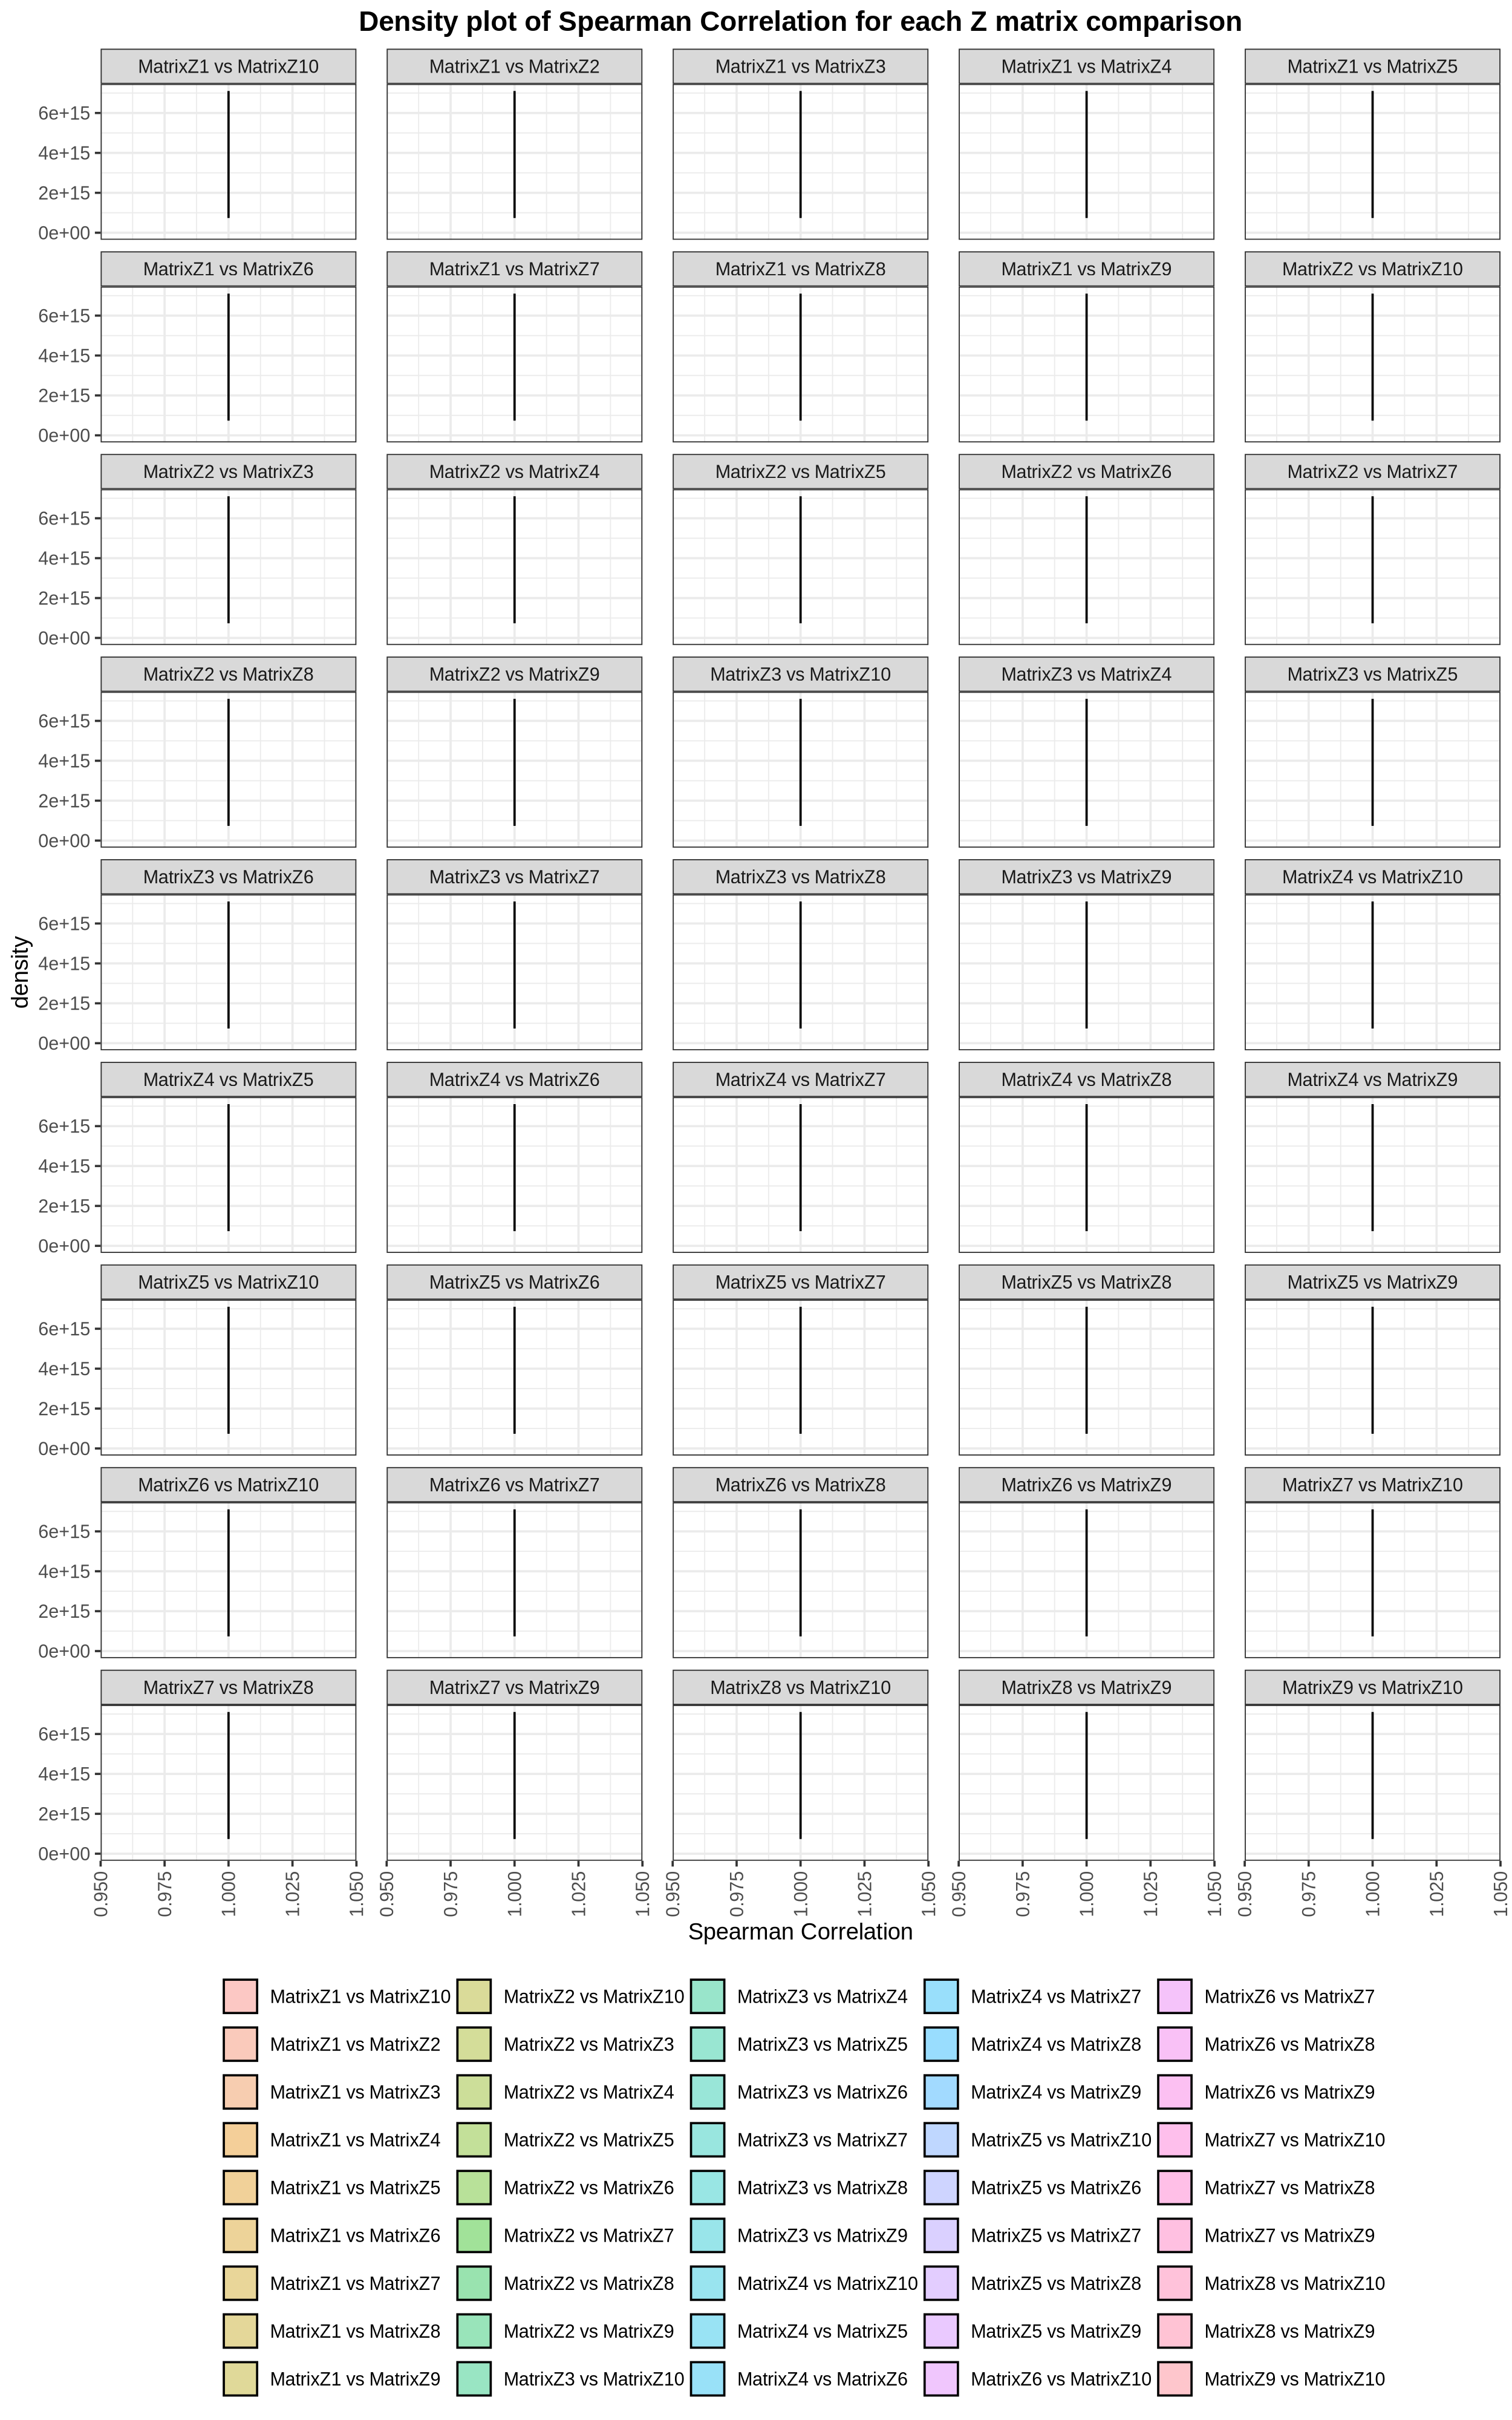

In [10]:
# Initialize a data frame to store results
results_cor <- data.frame(comparison = character(), correlation = numeric(), stringsAsFactors = FALSE)

# Compute Correlation for each combination
for (i in 1:(length(matricesZ) - 1)) {
  for (j in (i + 1):length(matricesZ)) {
    recon_cor <- GetReconstructionCorrelation(true.mat = matricesZ[[i]], recon.mat = matricesZ[[j]])
    comparison_name <- paste("MatrixZ", i, " vs MatrixZ", j, sep = "")
    results_cor <- rbind(results_cor, data.frame(comparison = comparison_name, correlation = recon_cor))
  }
}

# Convert correlation to a numeric vector to ensure proper plotting
results_cor$correlation <- as.numeric(results_cor$correlation)

options(warn=-1)
options(repr.plot.width = 10, repr.plot.height = 16, repr.plot.res = 250)


ggplot(results_cor, aes(x = correlation, fill = comparison)) +  
  geom_density(alpha = 0.4) +
  theme_bw() +
  labs(x = "Spearman Correlation", 
       title = "Density plot of Spearman Correlation for each Z matrix comparison") +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.title = element_blank(),
        legend.position = 'bottom',
               axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
        panel.spacing.x = unit(1, "lines")) +
  facet_wrap(~ comparison, ncol = 5)

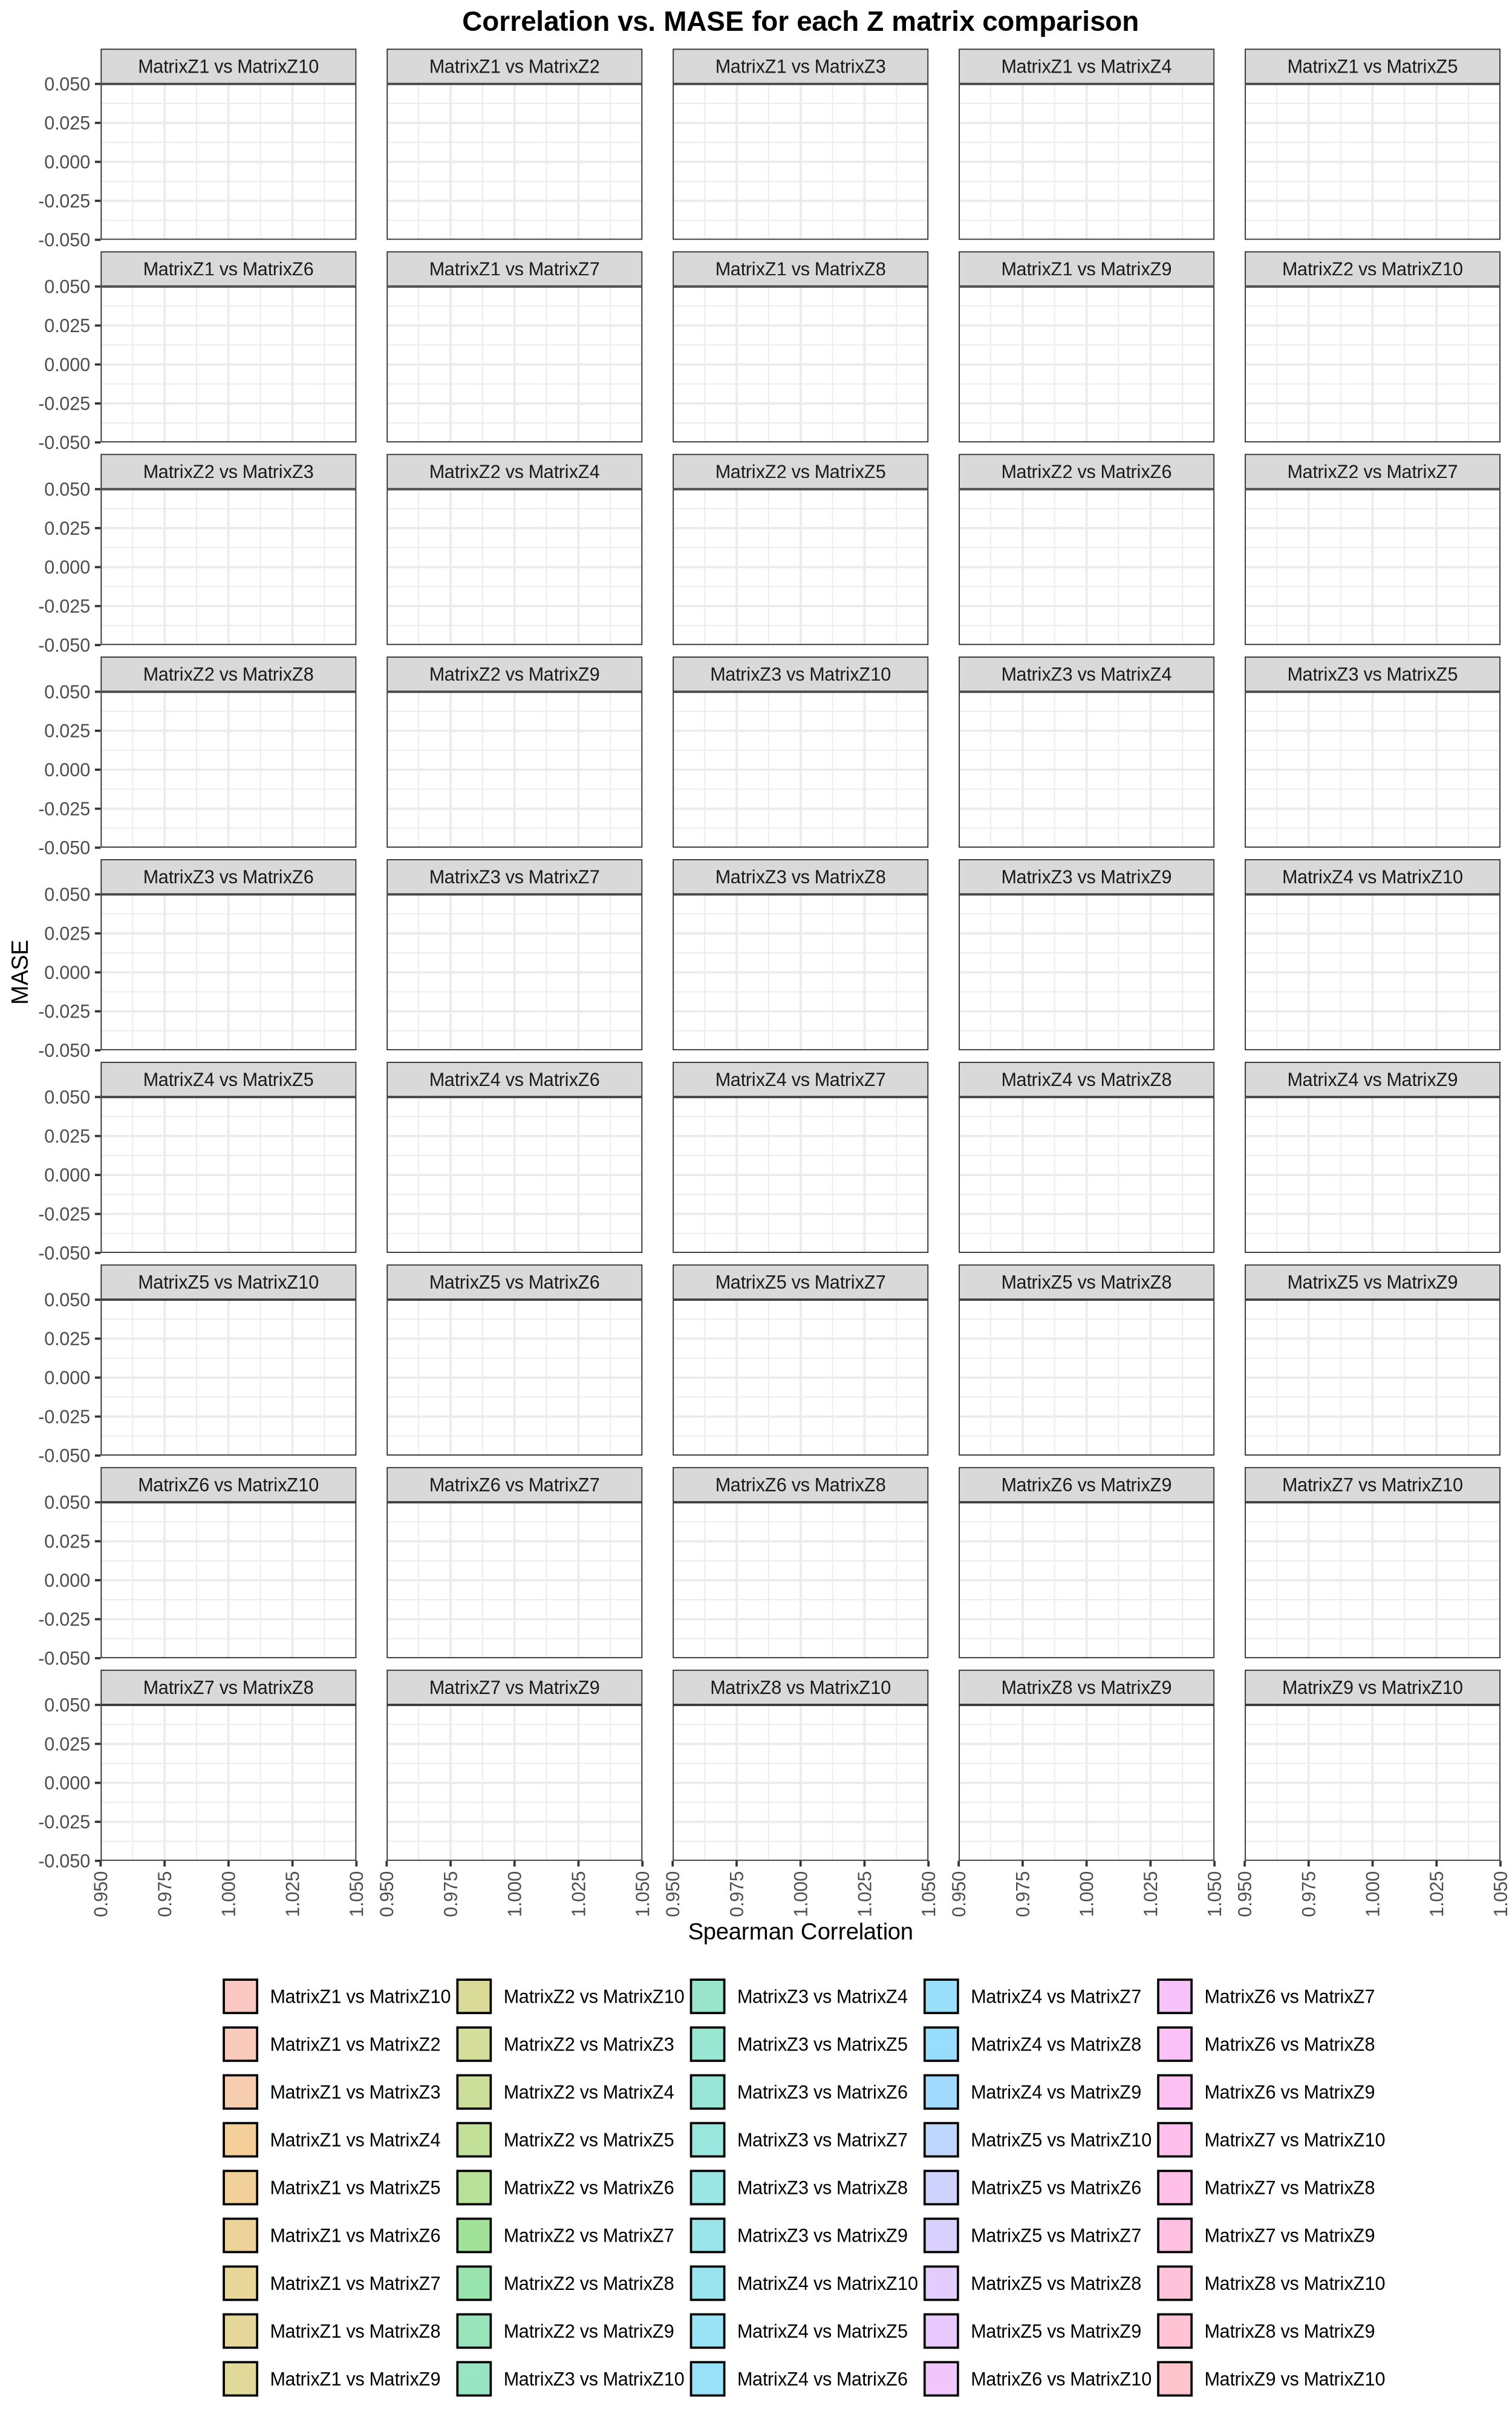

In [11]:
results_combined <- cbind(results_mase, results_cor[c('correlation')])
options(repr.plot.width = 10, repr.plot.height = 16, repr.plot.res = 250)


ggplot(results_combined, aes(x = correlation, y = mase, fill = comparison)) +  
  geom_density(alpha = 0.4) +
  theme_bw() +
  labs(x = "Spearman Correlation", 
       y = "MASE", 
       title = "Correlation vs. MASE for each Z matrix comparison") +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.title = element_blank(),
        legend.position = 'bottom',
               axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
        panel.spacing.x = unit(1, "lines")) +
  facet_wrap(~ comparison, ncol = 5)

**How similar are the B matrices along the different models?**

To study how similar are the B matrices we will calcuate:

- MASE (mean absolute scaled error) between the two B expression matrices.
- Spearman Correlation between the two B expression matrices.

We expected a low MASE and a high rho (arround 1) if the models are similar. 

We also expect a inverse correlation between MASE and Spearman Correlation.

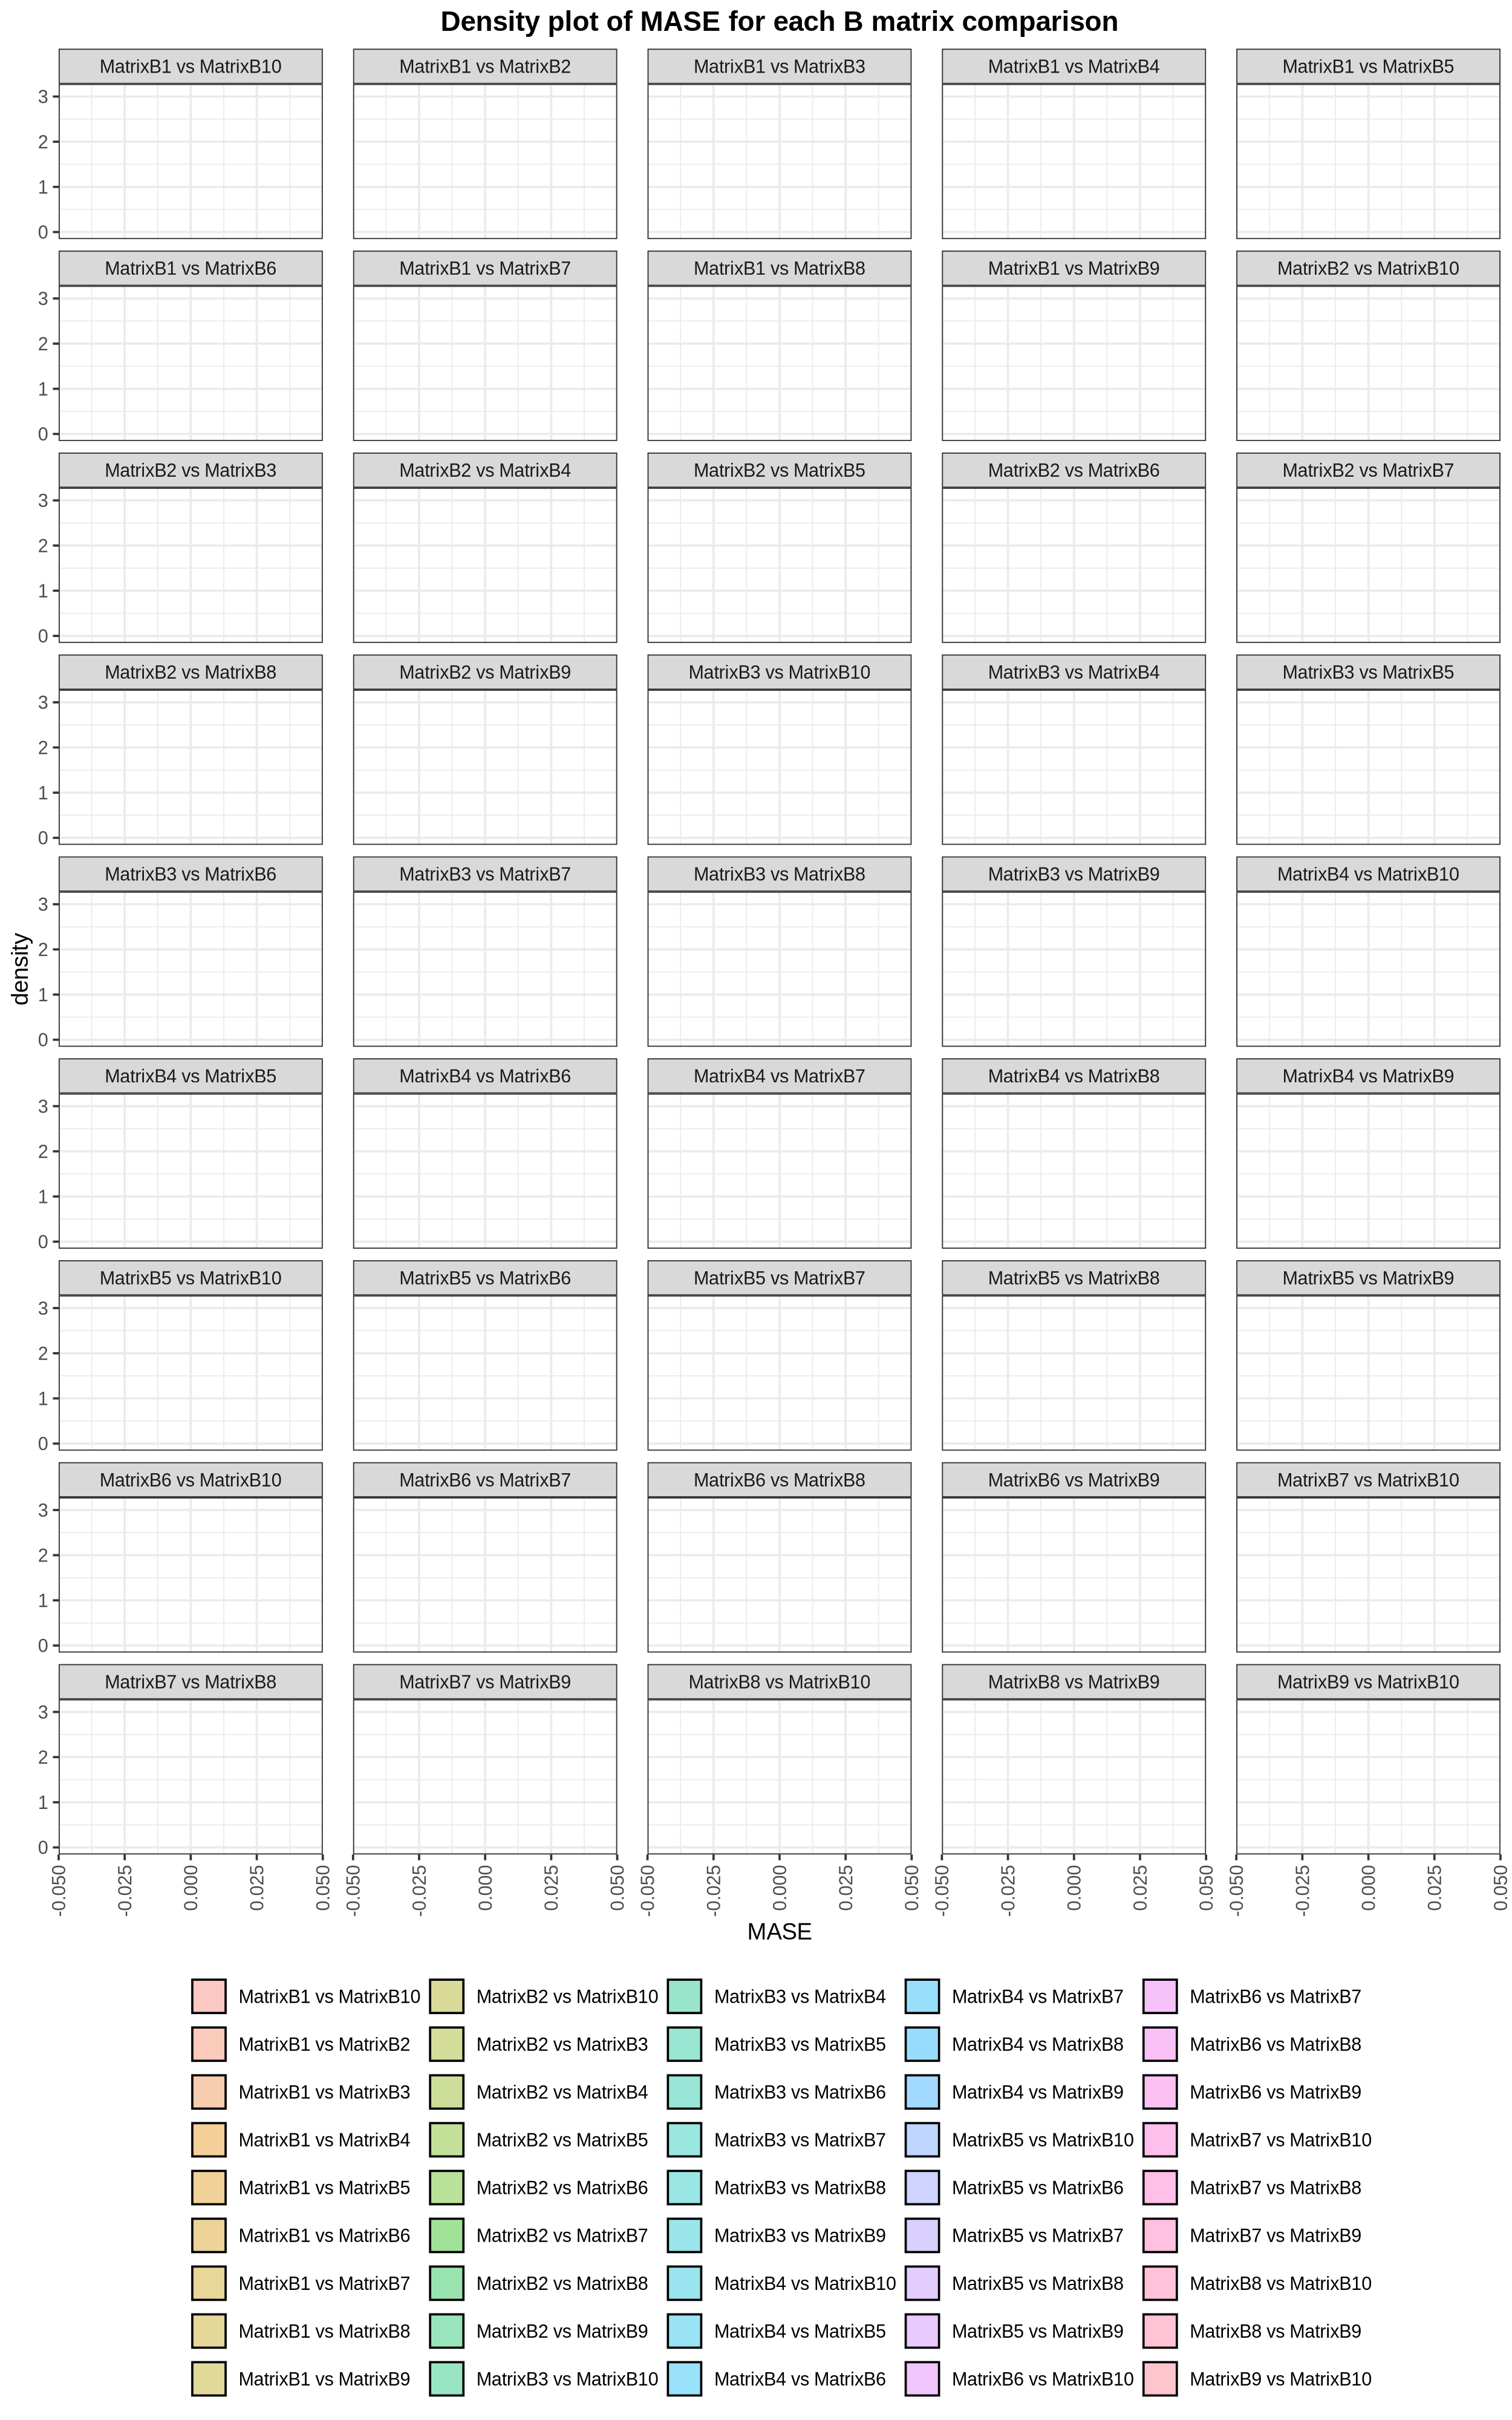

In [12]:
matricesB <- extracted_values$B

results_mase <- data.frame()

# Compute MASE for each combination
for (i in 1:(length(matricesB) - 1)) {
  for (j in (i + 1):length(matricesB)) {
    mase_value <- GetReconstructionMASE(matricesB[[i]], matricesB[[j]])
    comparison_name <- paste("MatrixB", i, " vs MatrixB", j, sep = "")
    tmp_df=data.frame(comparison=comparison_name, mase=mase_value)
    results_mase <- rbind(results_mase, data.frame(comparison = comparison_name, mase = mase_value))
  }
}

# Convert mase to a numeric vector to ensure proper plotting
results_mase$mase <- as.numeric(results_mase$mase)

options(repr.plot.width = 10, repr.plot.height = 16, repr.plot.res = 250)

ggplot(results_mase, aes(x = mase, fill = comparison)) +  
  geom_density(alpha = 0.4) +
  theme_bw() +
  labs(x = "MASE", 
       title = "Density plot of MASE for each B matrix comparison") +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.title = element_blank(),
        legend.position = 'bottom',
               axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
        panel.spacing.x = unit(1, "lines")) +
  facet_wrap(~ comparison, ncol = 5)

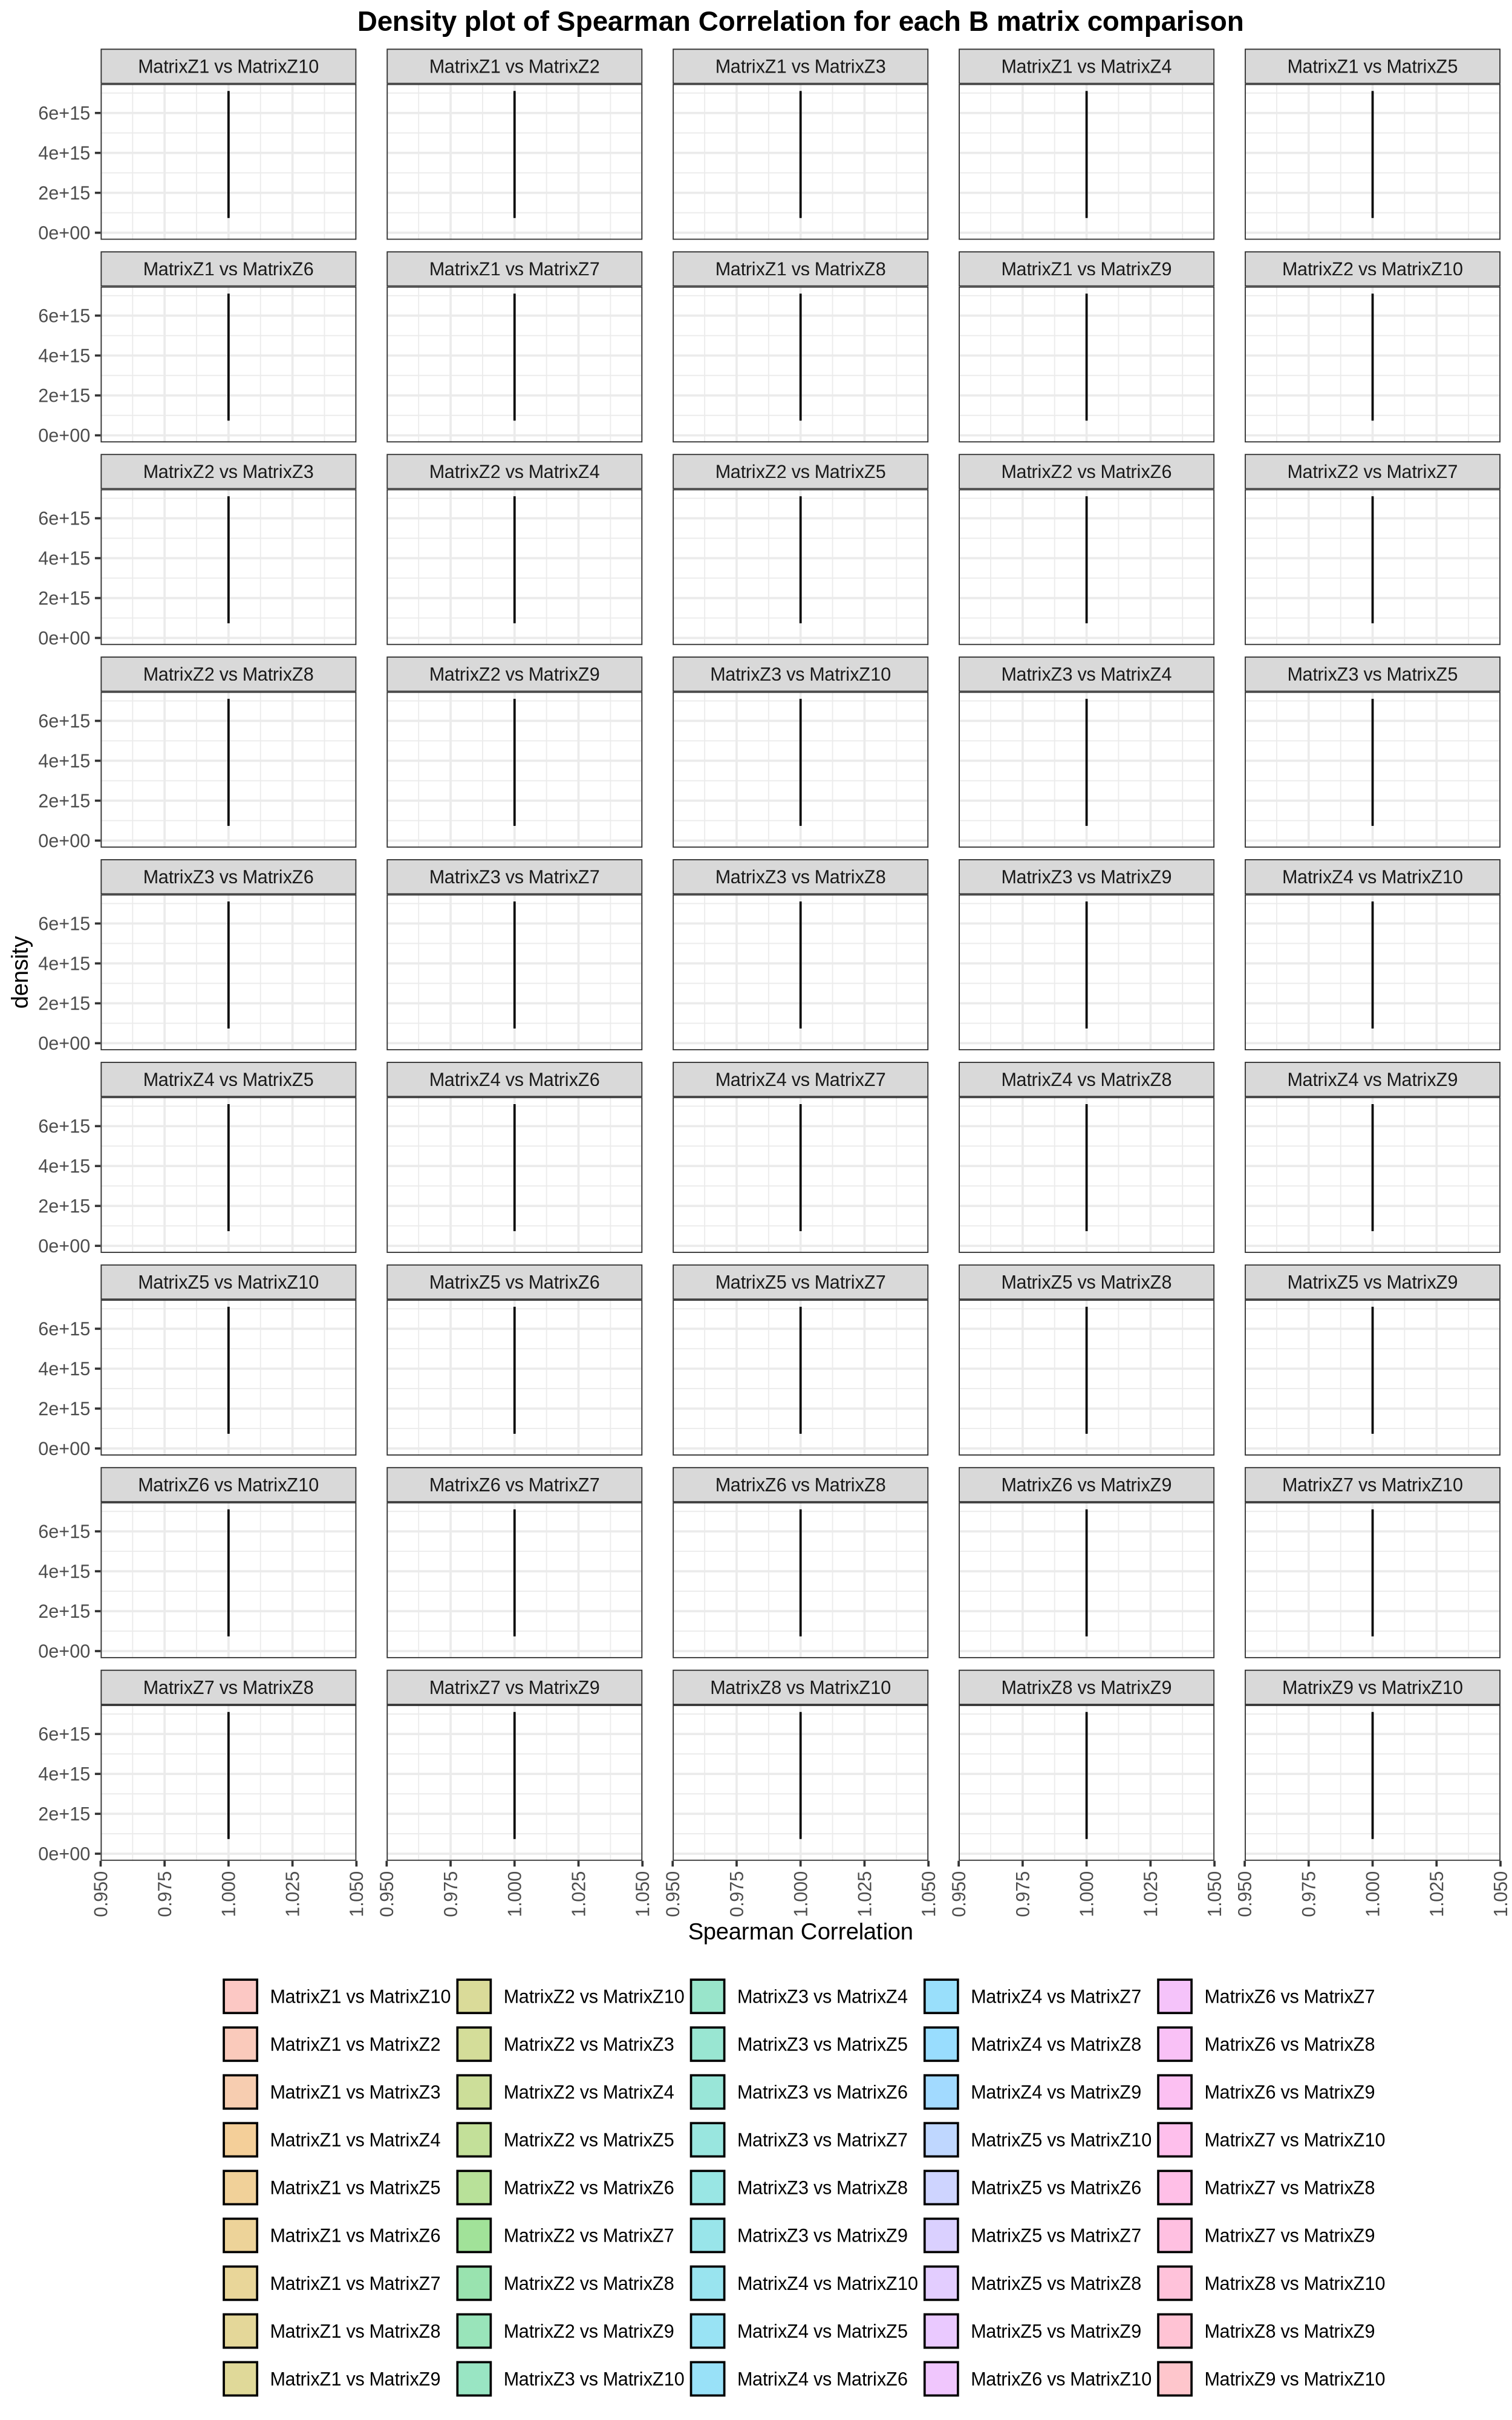

In [13]:
ggplot(results_cor, aes(x = correlation, fill = comparison)) +  
  geom_density(alpha = 0.4) +
  theme_bw() +
  labs(x = "Spearman Correlation", 
       title = "Density plot of Spearman Correlation for each B matrix comparison") +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.title = element_blank(),
        legend.position = 'bottom',
               axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
        panel.spacing.x = unit(1, "lines")) +
  facet_wrap(~ comparison, ncol = 5)

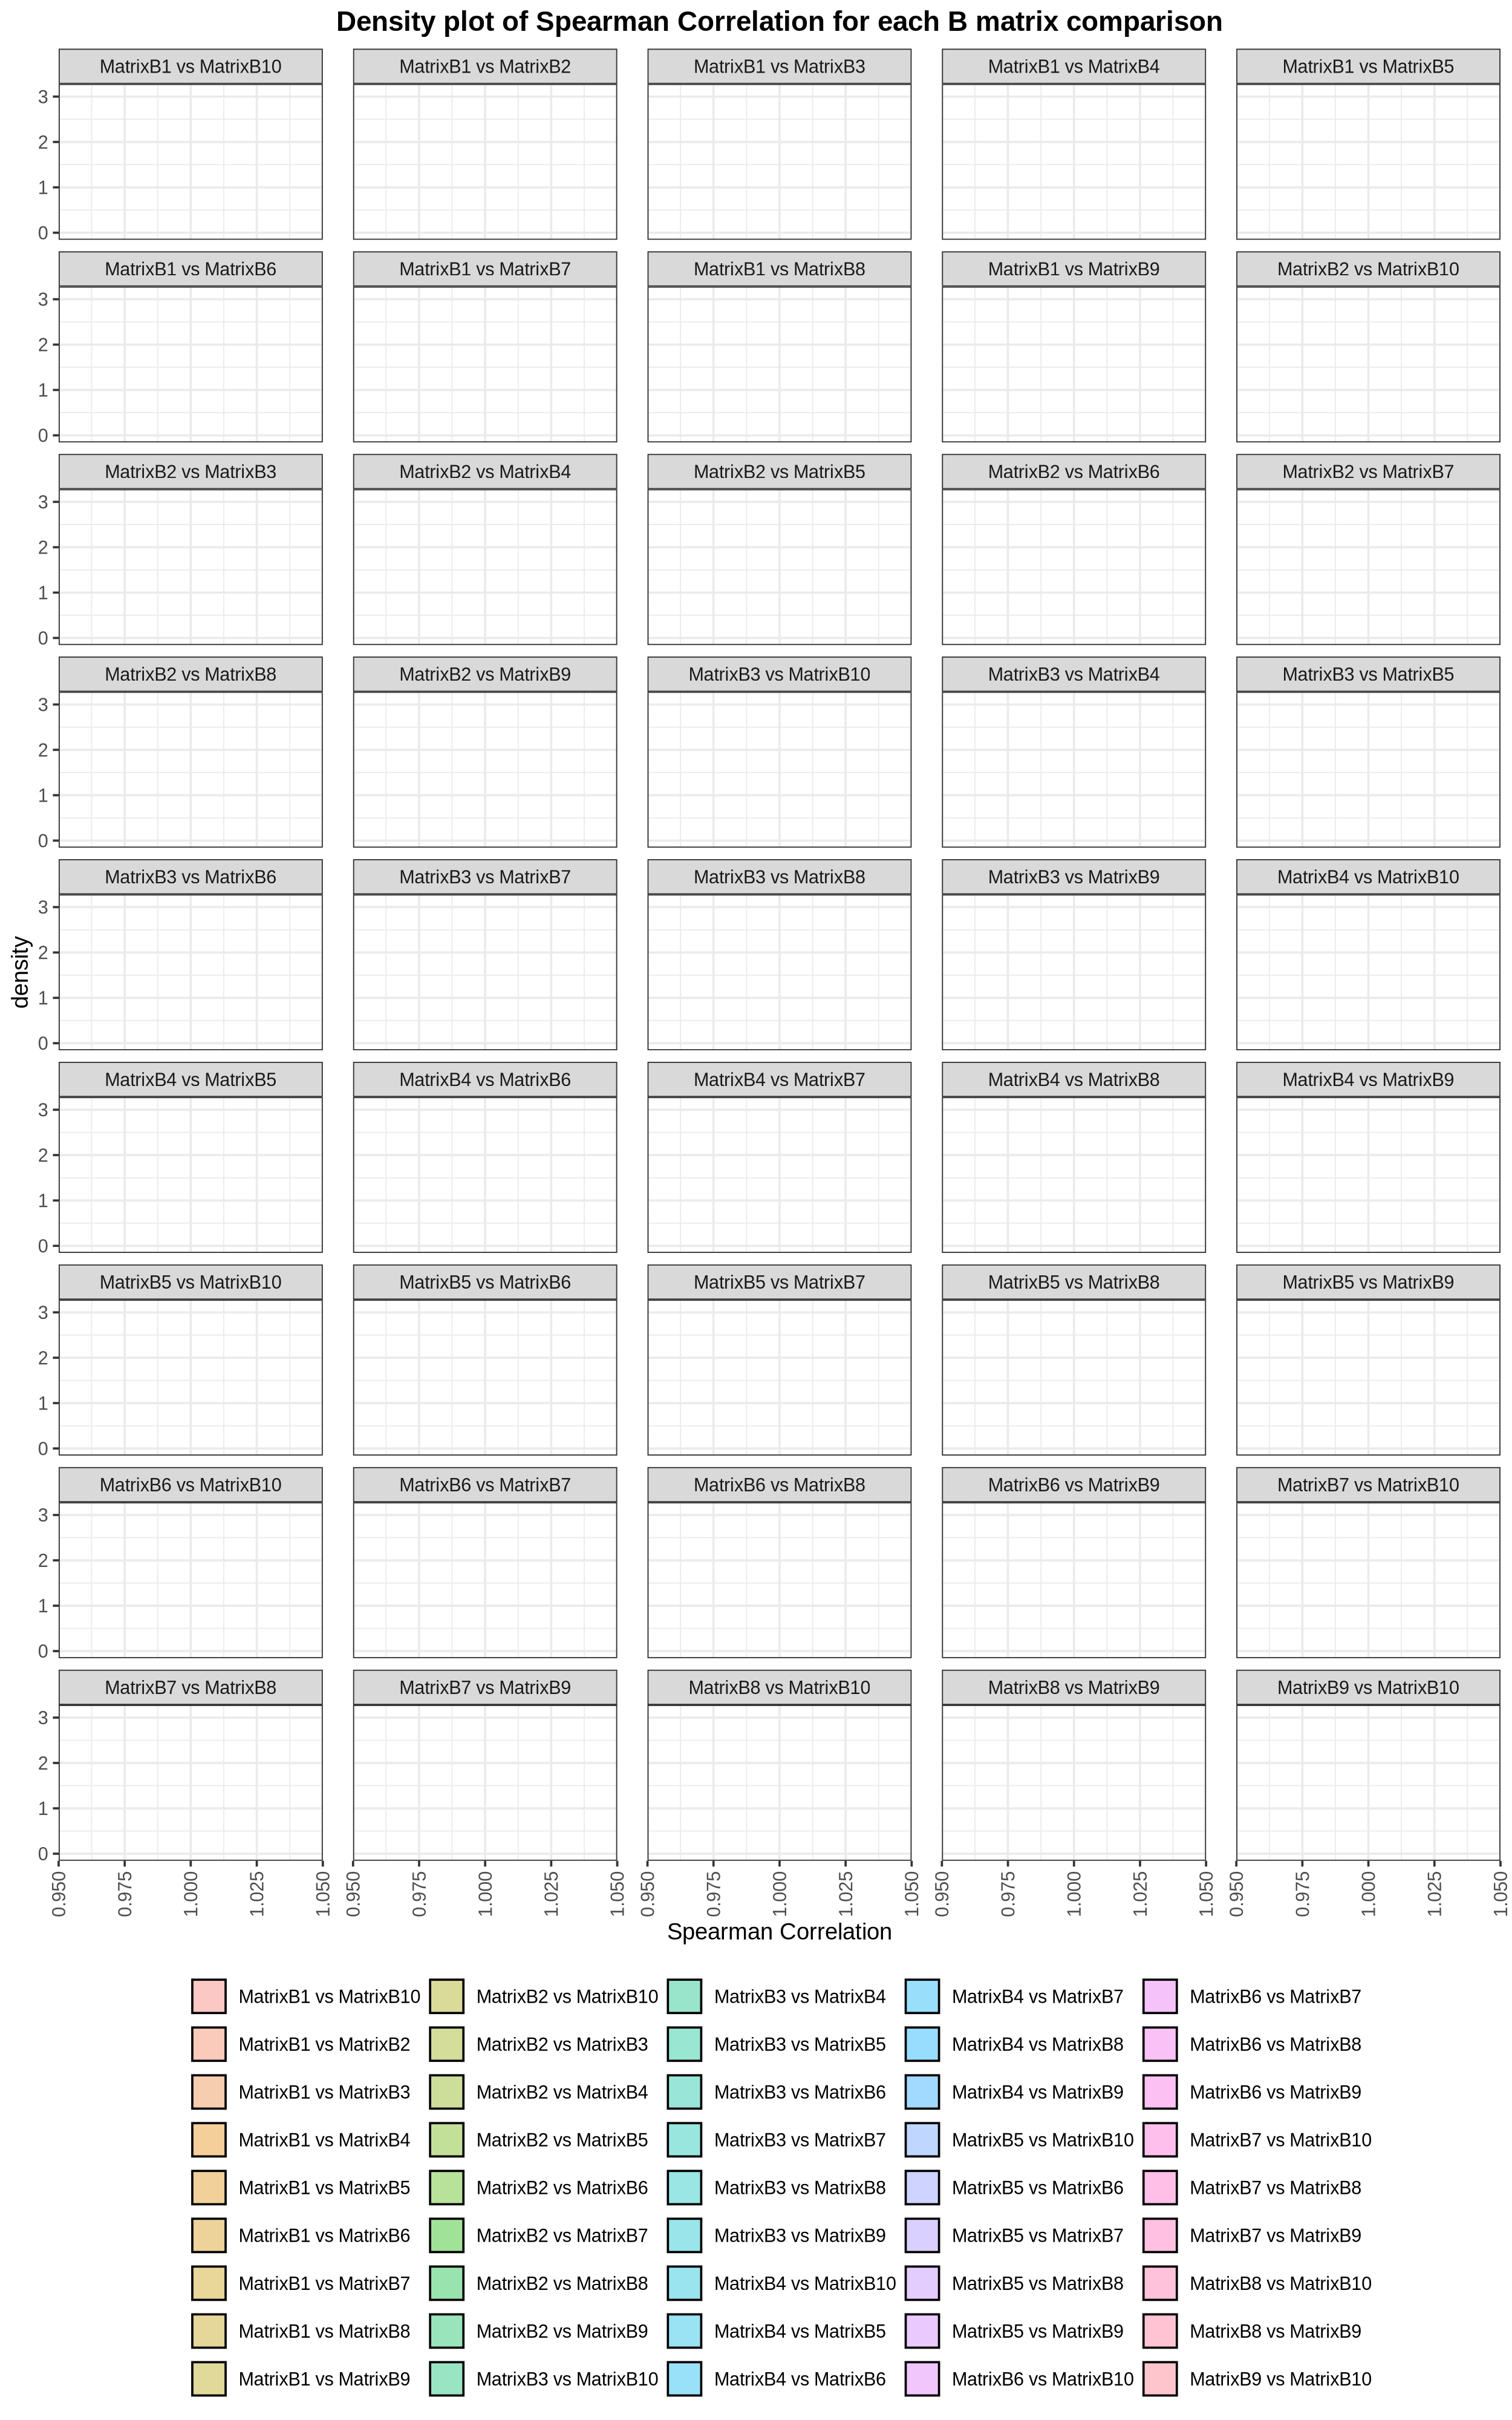

In [14]:
# Initialize a data frame to store results
results_cor <- data.frame(comparison = character(), correlation = numeric(), stringsAsFactors = FALSE)

# Compute Correlation for each combination
for (i in 1:(length(matricesB) - 1)) {
  for (j in (i + 1):length(matricesB)) {
    recon_cor <- GetReconstructionCorrelation(true.mat = matricesB[[i]], recon.mat = matricesB[[j]])
    comparison_name <- paste("MatrixB", i, " vs MatrixB", j, sep = "")
    results_cor <- rbind(results_cor, data.frame(comparison = comparison_name, correlation = recon_cor))
  }
}

# Convert correlation to a numeric vector to ensure proper plotting
results_cor$correlation <- as.numeric(results_cor$correlation)

options(warn=-1)
options(repr.plot.width = 10, repr.plot.height = 16, repr.plot.res = 250)

ggplot(results_cor, aes(x = correlation, fill = comparison)) +  
  geom_density(alpha = 0.4) +
  theme_bw() +
  labs(x = "Spearman Correlation", 
       title = "Density plot of Spearman Correlation for each B matrix comparison") +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.title = element_blank(),
        legend.position = 'bottom',
               axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
        panel.spacing.x = unit(1, "lines")) +
  facet_wrap(~ comparison, ncol = 5)

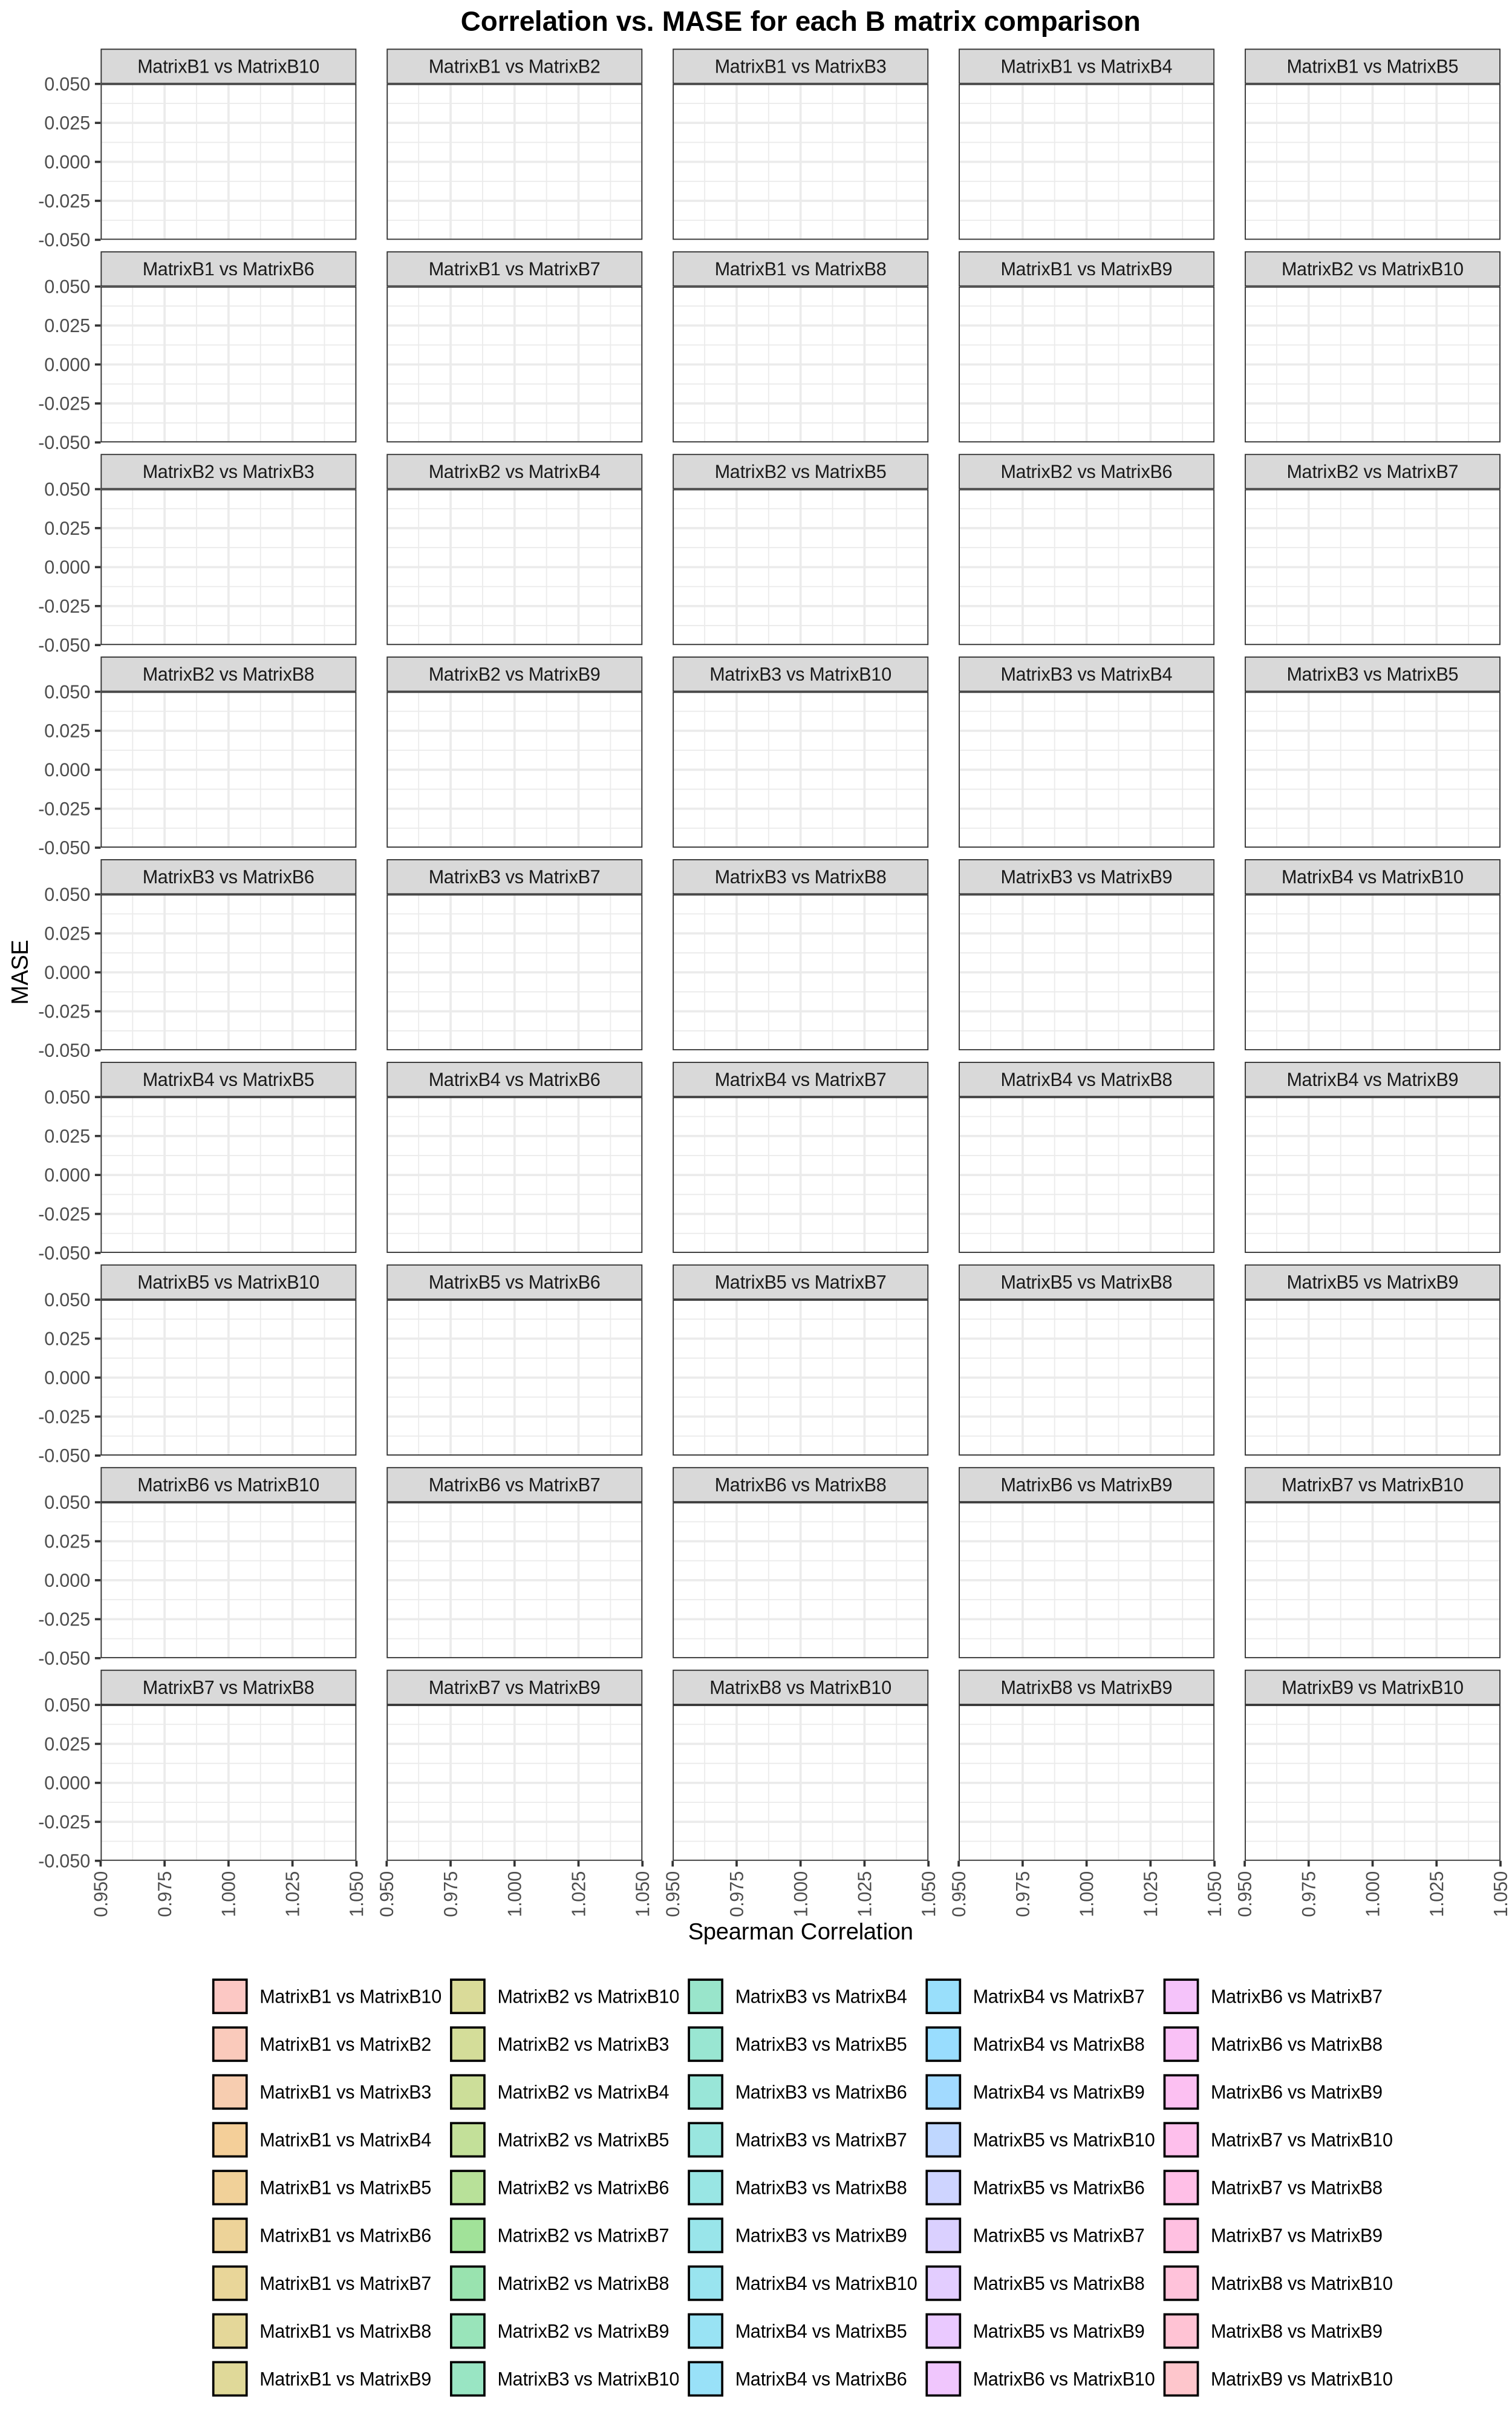

In [15]:
results_combined <- cbind(results_mase, results_cor[c('correlation')])

options(repr.plot.width = 10, repr.plot.height = 16, repr.plot.res = 250)


ggplot(results_combined, aes(x = correlation, y = mase, fill = comparison)) +  
  geom_density(alpha = 0.4) +
  theme_bw() +
  labs(x = "Spearman Correlation", 
       y = "MASE", 
       title = "Correlation vs. MASE for each B matrix comparison") +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.title = element_blank(),
        legend.position = 'bottom',
               axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
        panel.spacing.x = unit(1, "lines")) +
  facet_wrap(~ comparison, ncol = 5)

**How similar is the coverage in pathways and LVs assosiated with them?**

- Pathway: This represents the proportion of "covered" pathways within the analysis. A "covered" pathway refers to a pathway that has been identified.

- LV (Latent Variable): This is about the proportion of LVs that have pathways associated with them. The proportion here indicates how many of these LVs have at least one associated pathway, suggesting a linkage or influence between the LVs and the pathways in question.

- Sig. Pathway by LV: This metric calculates the number of pathways "covered" divided by the number of LVs. Essentially, it provides a ratio indicating the average number of pathways associated with each LV. A higher ratio suggests that, on average, each LV is associated with multiple pathways, which could indicate a more complex relationship between the LVs and the pathways, or possibly a higher degree of coverage and significance in the analysis.

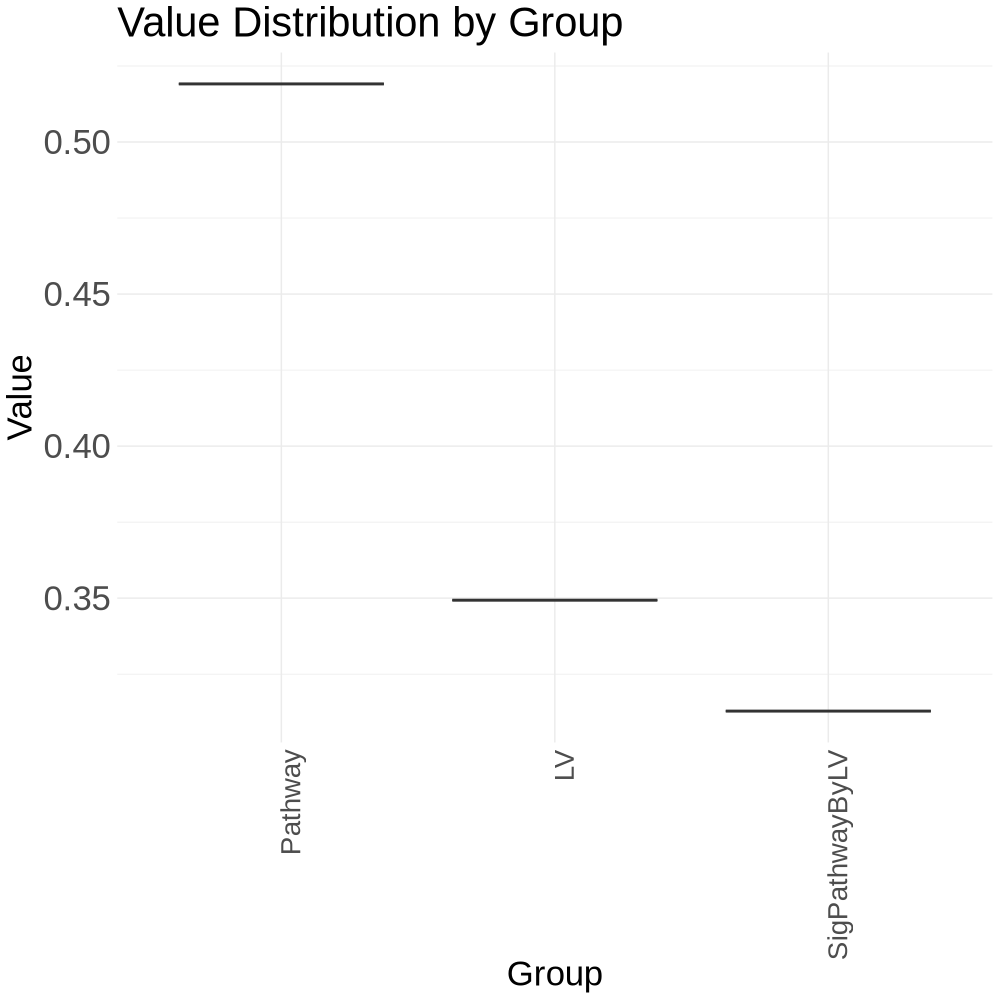

In [16]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 100)

gtex_rob_models_coverage=lapply(gtex_rob_models, GetPathwayCoverage)
pathways <- numeric(length(gtex_rob_models_coverage))
lvs <- numeric(length(gtex_rob_models_coverage))
sig_pathways_by_lv <- numeric(length(gtex_rob_models_coverage))

# Now we loop over the list and extract the values
for (i in seq_along(gtex_rob_models_coverage)) {
  pathways[i] <- gtex_rob_models_coverage[[i]]$pathway
  lvs[i] <- gtex_rob_models_coverage[[i]]$lv
  sig_pathways_by_lv[i] <- gtex_rob_models_coverage[[i]]$sig.pathway.by.lv
}

gtex_df <- data.frame(
  Index = seq_along(gtex_rob_models_coverage),
  Pathway = pathways,
  LV = lvs,
  SigPathwayByLV = sig_pathways_by_lv
)

gtex_melted <- melt(gtex_df, id.vars = 'Index')


ggplot(gtex_melted, aes(x = variable, y = value)) + 
    geom_boxplot() +
    labs(title = "Value Distribution by Group",
       x = "Group",
       y = "Value") +
    theme_minimal() +
    theme(
    axis.text.x = element_text(size = 20, angle = 90, hjust = 1),  # Rotate x-axis labels by 90 degrees
    axis.text.y = element_text(size = 25),  # Adjust y-axis text size
    text = element_text(size = 25)  # Adjust other text sizes (plot title, axis labels, etc.)
)